In [1]:
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
filename = Path('..', 'data', 'sgpmetE13.b1', 'sgpmetE13.b1.20191101.000000.cdf')

This is a list of names to not attempt to read. Notice there is one name listed in the array that does not exist in the netCDF file. Xarray is cool with that.

In [3]:
drop_vars = ['base_time', 'time_offset', 'vapor_pressure_std', 'wspd_arith_mean',
             'qc_wspd_arith_mean', 'wspd_vec_mean', 'qc_wspd_vec_mean',
             'wdir_vec_mean', 'qc_wdir_vec_mean', 'wdir_vec_std', 'tbrg_precip_total',
             'qc_tbrg_precip_total', 'tbrg_precip_total_corr', 'qc_tbrg_precip_total_corr',
             'org_precip_rate_mean', 'qc_org_precip_rate_mean', 'pwd_err_code',
             'pwd_mean_vis_1min', 'qc_pwd_mean_vis_1min', 'pwd_mean_vis_10min',
             'qc_pwd_mean_vis_10min', 'pwd_pw_code_inst', 'qc_pwd_pw_code_inst',
             'pwd_pw_code_15min', 'qc_pwd_pw_code_15min', 'pwd_pw_code_1hr',
             'qc_pwd_pw_code_1hr', 'pwd_precip_rate_mean_1min',
             'qc_pwd_precip_rate_mean_1min', 'pwd_cumul_rain', 'qc_pwd_cumul_rain',
             'pwd_cumul_snow', 'qc_pwd_cumul_snow', 'logger_volt', 'qc_logger_volt',
             'logger_temp', 'qc_logger_temp', 'temp_std',
             'rh_std', 'vapor_pressure_mean', 'qc_vapor_pressure_mean',
             'a_very_long_name_that_is_not_in_the_data_file']

Notice how we change the pathlib to a string in the call. This is required because we are using .open_mfdataset() instead of .open_dataset().

In [4]:
ds = xr.open_mfdataset(str(filename), drop_variables=drop_vars)

In [5]:
print(ds)

<xarray.Dataset>
Dimensions:            (time: 1440)
Coordinates:
  * time               (time) datetime64[ns] 2019-11-01 ... 2019-11-01T23:59:00
Data variables:
    atmos_pressure     (time) float32 dask.array<chunksize=(1440,), meta=np.ndarray>
    qc_atmos_pressure  (time) int32 dask.array<chunksize=(1440,), meta=np.ndarray>
    temp_mean          (time) float32 dask.array<chunksize=(1440,), meta=np.ndarray>
    qc_temp_mean       (time) int32 dask.array<chunksize=(1440,), meta=np.ndarray>
    rh_mean            (time) float32 dask.array<chunksize=(1440,), meta=np.ndarray>
    qc_rh_mean         (time) int32 dask.array<chunksize=(1440,), meta=np.ndarray>
    lat                float32 ...
    lon                float32 ...
    alt                float32 ...
Attributes: (12/29)
    command_line:                met_ingest -s sgp -f E13
    process_version:             ingest-met-4.40-0.el7
    dod_version:                 met-b1-7.3
    input_source:                /data/collection/sg

Since we are using Xarray as the object storing the data we can use builtin methods to plot the data. But understand the plotting calls are using Matplotlib. There is just some assumptions going on in the call about getting the x and y axis lables.

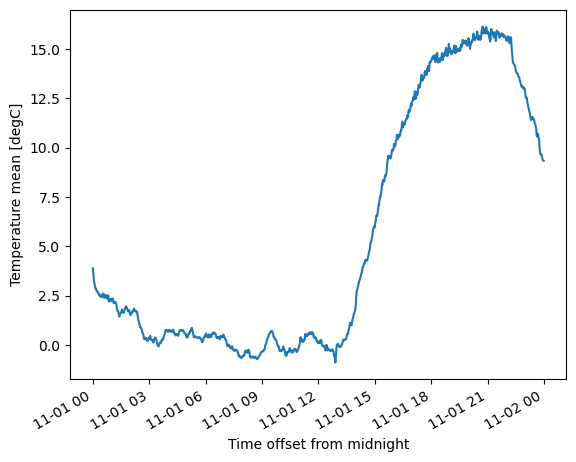

In [6]:
ds['temp_mean'].plot()

Here we make two plots. Syntax is slightly different than calling matplotlib directly. Plot has some issues with how Xarray makes assumptions on how to handle labels. But not bad for right out of the box.

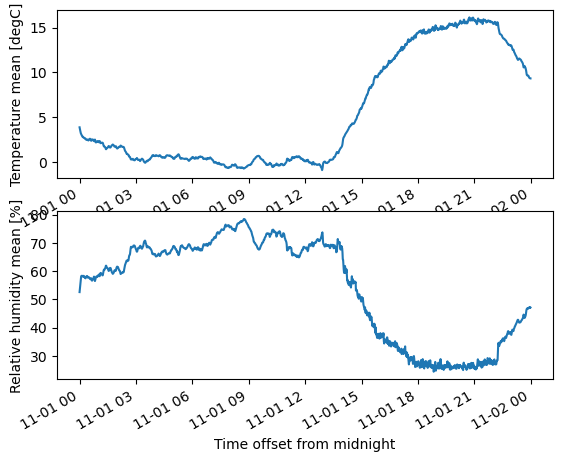

In [7]:
fig, axes = plt.subplots(nrows=2)
ds['temp_mean'].plot(ax=axes[0])
ds['rh_mean'].plot(ax=axes[1])

### Make a plot.
Let's read in some 2-D data and make a plot.

In [8]:
filename = Path('..', 'data', 'sgpceilC1.b1', 'sgpceilC1.b1.20191103.000012.nc')
ds = xr.open_dataset(filename)

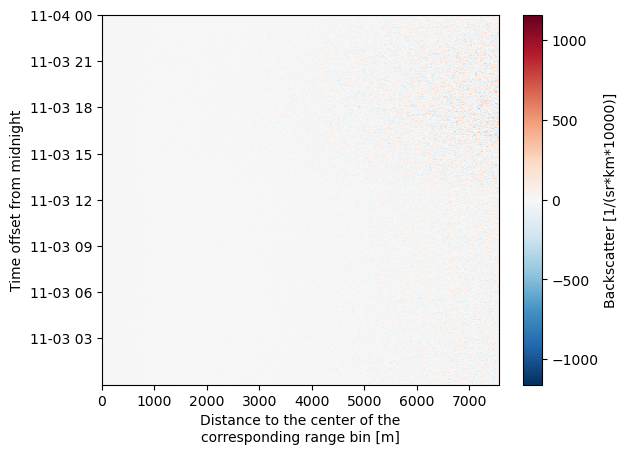

In [9]:
ds['backscatter'].plot()

Things are not quite what you want!?!? Where do we begin? The plot is actually being made by the matplotlib pclormesh() call. But we don't know that initially so finding all the right keywords could be hard. Is there a different way? Yes, look into documentation.

## A more true type of plot you will want to create.
Lets pause with Xarray plotting and start with the library that is making the plot, matplotlib. Once we understand what is going on underneath we can make the plots we want with the same/similar calls with Xarray.

First we read the data.

In [10]:
filename = Path('..', 'data', 'sgpmetE13.b1', 'sgpmetE13.b1.20191104.000000.cdf')
ds = xr.open_dataset(filename)

It will always save you time in the future if you can reduce the number of hardcoded values in the function calls. This seems like extra work but it will save you loads of time later on. I suggest to put these variables at the top of your code so you can change in one place and rerun code to make changes.

In [11]:
var_name = 'temp_mean'
var_name2 = 'rh_mean'

First we want to update the data to be correct units. Luckily someone has created a librray to make that a simple process.

In [12]:
import pint  # Library to do unit conversion.
desired_temp_unit = 'degF'  # The correct term matters. Follow UDUNITS.
ureg = pint.UnitRegistry()  # Set up the regestry object.
data = ds[var_name].values  # Get the data from Xarray object.

Now we use the units registry with the units in the Xarray object to tell Pint what current units the data are set with. Notice that data is no longer just a numpy array. It is now appended with a units object.

In [13]:
variable_units = ds[var_name].attrs['units']
data = data * ureg.parse_expression(variable_units)
data = data.to(ureg.parse_expression(desired_temp_unit))

We changed the data but we need put it back into the Dataset. We also need to update the units attribute in the Dataset or else we will be very confused when we go to use the Dataset.

In [14]:
ds[var_name].values = data.magnitude
ds[var_name].attrs['units'] = desired_temp_unit

Create the figure (the blank white space) and the axes (the box where plotted data goes and set variabls to call later.

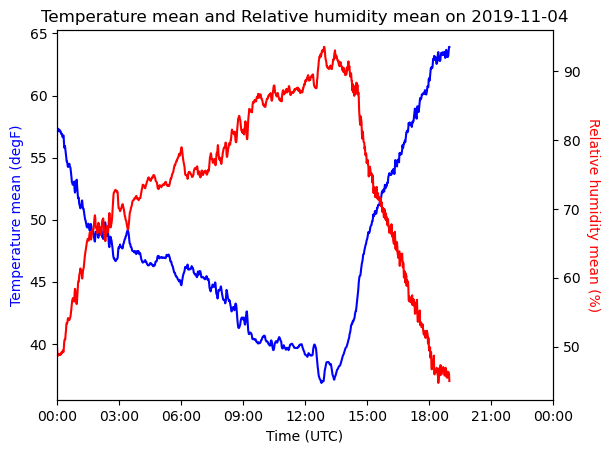

In [15]:
import matplotlib.dates as mdates
fig, axes = plt.subplots()  # default figsize=(8, 6)

# Now make the plot by extracting the time and data from object.
# matplotlib is smart enough to extract what it needs if you pass it the
# Xarray DataArray instead of a Numpy array.
line1_color = 'blue'
line1 = axes.plot(ds['time'], ds[var_name], color=line1_color)

# Format the x-axis to show hour and minutes only.
myFmt = mdates.DateFormatter('%H:%M')
axes.xaxis.set_major_formatter(myFmt)

# Get the first time value from the object
first_time = ds['time'].values[0]

# Change the precision of the time value from sub-second to day.
# Then add one day to that value to set the end of the range value.
xrng = [first_time.astype('datetime64[D]'),
        first_time.astype('datetime64[D]') + 1]

# Set the xrange for plot window. Notice how there is a gap in data at end of day now.
axes.set_xlim(xrng)

# Now lets be a real scientist and add some axis labels. Using the metadata from the
# DataArray get the axis label text create the lable by combining long name with units
y_label = f"{ds[var_name].attrs['long_name']} ({ds[var_name].attrs['units']})"

# Now set the text for the y-axis. Notice we set the color to match the line plotted.
axes.set_ylabel(y_label, color=line1_color)

# Set the x-axis label.
axes.set_xlabel('Time (UTC)')  

# But when you plot temperature you typically want to plot RH too.
# How about on the same plot? (Wow mind blown!)
axes_right = axes.twinx()  # Create a new y-axis but share same x-axis.
line2_color = 'red'  # Set a variable to the string name RH line color

# Plot the RH data on the new right axis, using the line2_color.
line2 = axes_right.plot(ds['time'], ds[var_name2], color=line2_color)

# Add axis label to right. We add some additional keywords to make more pretty.
y_label2 = f"{ds[var_name2].attrs['long_name']} ({ds[var_name2].attrs['units']})"
axes_right.set_ylabel(y_label2, color=line2_color, rotation=-90, va='bottom')

# And the most important part of all, a title.
text = (f"{ds[var_name].attrs['long_name']} and {ds[var_name2].attrs['long_name']} on "
        f"{first_time.astype('datetime64[D]')}")
ignore = axes.set_title(text)

## Wouldn't it be nice if there was a function to do all this for you already? Well there is, and we'll get there soon...